# Тематическе моделирование

Что надо сделать:
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [ ]:
# Рабочий вариант зависимостей для визуализации результатов работы LDA модели
#  на момент август 2023 года.
!pip install pandas==1.5.3
!pip install numpy==1.18
!pip install -q pyLDAvis

In [ ]:
!pip install -q pymorphy2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re
import nltk
import json
import string
import pymorphy2
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import ldamodel, CoherenceModel
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('drive/MyDrive/positive.csv',
                       sep=';',
                       usecols=[3],
                       names=['text'])
negative = pd.read_csv('drive/MyDrive/negative.csv',
                       sep=';',
                       usecols=[3],
                       names=['text'])

df = pd.concat([positive, negative])

In [ ]:
df.shape

(226834, 1)

In [ ]:
df.head()

,text
0,"@first_timee хоть я и школота, но поверь, у на..."
1,"Да, все-таки он немного похож на него. Но мой ..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...
3,"RT @digger2912: ""Кто то в углу сидит и погибае..."
4,@irina_dyshkant Вот что значит страшилка :D\nН...


# Preprocessing

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
nltk.download('stopwords')
words_regex = re.compile('\w+')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Загрузим дополнительные стоп-слова
!wget https://github.com/stopwords-iso/stopwords-ru/blob/master/stopwords-ru.json

--2023-08-16 11:33:26--  https://github.com/stopwords-iso/stopwords-ru/blob/master/stopwords-ru.json
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13050 (13K) [text/plain]
Saving to: ‘stopwords-ru.json’

stopwords-ru.json   100%[===================>]  12.74K  --.-KB/s    in 0.02s   

2023-08-16 11:33:27 (708 KB/s) - ‘stopwords-ru.json’ saved [13050/13050]



In [ ]:
f = open('stopwords-ru.json')
data = json.load(f)
f.close()

In [ ]:
extended_words = list(data)
stopwords_list = stopwords.words('russian') + extended_words

In [ ]:
def find_words(text, regex=words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]

def lemmatize(words, lemmer=morph, stopwords=stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [ ]:
df.text.iloc[1]

'Да, все-таки он немного похож на него. Но мой мальчик все равно лучше:D'

In [ ]:
print(preprocess(df.text.iloc[1]))

['всё', 'таки', 'немного', 'похожий', 'мальчик', 'всё', 'равно', 'хороший']


In [ ]:
preprocessed_text = list(tqdm(map(preprocess, df['text']), total=len(df), desc='Progress'))

Progress:   0%|          | 0/226834 [00:00<?, ?it/s]

In [ ]:
df['preprocessed_text'] = preprocessed_text
df.head(3)

,text,preprocessed_text
0,"@first_timee хоть я и школота, но поверь, у на...","[школотый, поверь, самый, общество, профилиров..."
1,"Да, все-таки он немного похож на него. Но мой ...","[всё, таки, немного, похожий, мальчик, всё, ра..."
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,"[katiacheh, идиотка, испугаться]"


# LDA Modeling

In [ ]:
!pip install -U -q gensim

**Модель использует векторное представление документов, поэтому создадим словарь**

In [ ]:
dictionary = corpora.Dictionary(df['preprocessed_text'])

# игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.filter_extremes(no_below=10, no_above=0.9, keep_n=None)
dictionary.save('tweets.dict')

**Векторизуем документы**

In [ ]:
corpus = [dictionary.doc2bow(text) for text in df['preprocessed_text']]
corpora.MmCorpus.serialize('tweets.model', corpus)

**Обучение модели**

In [ ]:
%time

lda = ldamodel.LdaModel(corpus, id2word=dictionary,
                        num_topics=20,
                        chunksize=50,
                        update_every=1,
                        passes=2)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [ ]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(19,
  '0.260*"очень" + 0.237*"завтра" + 0.150*"идти" + 0.136*"школа" + 0.096*"мама" + 0.048*"работать" + 0.043*"спасибо" + 0.010*"главное" + 0.000*"спать" + 0.000*"холодно"'),
 (8,
  '0.280*"блин" + 0.213*"свой" + 0.157*"самый" + 0.111*"каждый" + 0.097*"посмотреть" + 0.042*"значит" + 0.023*"ощущение" + 0.020*"часть" + 0.013*"радовать" + 0.012*"факт"'),
 (9,
  '0.599*"http" + 0.178*"знать" + 0.131*"любить" + 0.066*"бля" + 0.010*"ухо" + 0.000*"делать" + 0.000*"вообще" + 0.000*"скучать" + 0.000*"ждать" + 0.000*"жизнь"'),
 (0,
  '0.750*"хотеть" + 0.151*"сидеть" + 0.040*"взять" + 0.029*"жрать" + 0.004*"поддержка" + 0.000*"спать" + 0.000*"дом" + 0.000*"делать" + 0.000*"домой" + 0.000*"нибыть"'),
 (7,
  '0.853*"всё" + 0.072*"пиздец" + 0.039*"прям" + 0.009*"рада" + 0.003*"заебись" + 0.001*"победить" + 0.000*"болеть" + 0.000*"большой" + 0.000*"плохо" + 0.000*"вроде"'),
 (18,
  '0.493*"весь" + 0.237*"сказать" + 0.105*"дело" + 0.092*"понять" + 0.021*"заметить" + 0.011*"сучка" + 0.010*"оля" + 0.

**Полученные темы спроецируем на плоскости**

In [ ]:
%time

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


In [ ]:
def report_lda():
    print('Perplexity: ', np.exp(lda.log_perplexity(corpus)))

    coherence_model_lda = CoherenceModel(model=lda, texts=df['preprocessed_text'],
                                     dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Average coherence: ', coherence_lda)

In [ ]:
report_lda()

**Подберём оптимальное количество тем, опираясь на метрики**

  0%|          | 0/3 [00:00<?, ?it/s]

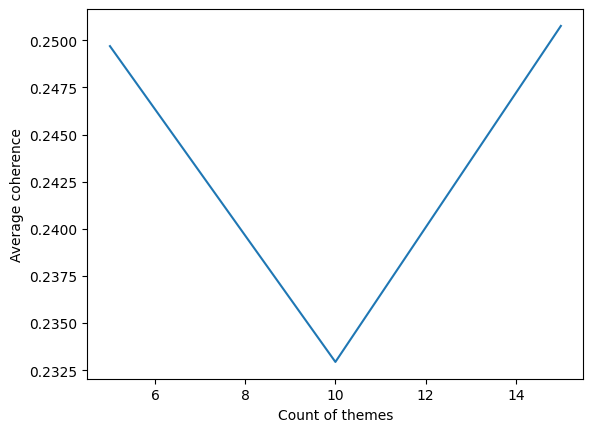

In [ ]:
topics_list = [5, 10, 15]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num,
                            chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['preprocessed_text'],
                                     dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Count of themes")
plt.ylabel("Average coherence")
plt.show();

**Попробуем взять 15 тем**

In [ ]:
%%time

lda = ldamodel.LdaModel(corpus, id2word=dictionary,
                        num_topics=15,
                        chunksize=50,
                        update_every=1,
                        passes=2)
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

CPU times: user 4min 47s, sys: 942 ms, total: 4min 48s
Wall time: 4min 56s


**Посмотрим на метрики**

In [ ]:
report_lda()

Perplexity:  2.546402054798288e-07
Average coherence:  0.23973374244673104


**Метрики стали получше**

In [ ]:
vis_data.topic_info.Category

15      Default
39      Default
6       Default
24      Default
18      Default
         ...   
2068    Topic15
1370    Topic15
480     Topic15
3670    Topic15
9220    Topic15
Name: Category, Length: 480, dtype: object

In [ ]:
topic_names_list = vis_data.topic_info.Category.unique()

topic_names_list

array(['Default', 'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5',
       'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11',
       'Topic12', 'Topic13', 'Topic14', 'Topic15'], dtype=object)

**Взглянем на топики**

In [ ]:
for topic_name in topic_names_list[1:]:
    print(list(vis_data.topic_info.loc[vis_data.topic_info.Category == topic_name].Term[:8]))

['всё', 'мочь', 'сегодня', 'казаться', 'пора', 'слово', 'получиться', 'столько']
['http', 'говорить', 'стать', 'зима', 'киев', 'украина', 'ребята', 'нечего']
['блин', 'свой', 'скучать', 'год', 'утро', 'каждый', 'настроение', 'посмотреть']
['человек', 'сказать', 'хороший', 'самый', 'твой', 'любимый', 'дело', 'написать']
['завтра', 'идти', 'спать', 'школа', 'урок', 'понимать', 'последний', 'первый']
['день', 'смотреть', 'пойти', 'час', 'никто', 'нужно', 'второй', 'пиздец']
['это', 'неделя', 'голова', 'плохой', 'маленький', 'ужасный', 'чувство', 'наверное']
['весь', 'любить', 'жизнь', 'мама', 'читать', 'понять', 'рука', 'жить']
['хотеть', 'просто', 'сидеть', 'хотя', 'ужасно', 'бог', 'сильно', 'уйти']
['знать', 'вообще', 'писать', 'хотеться', 'друг', 'бля', 'фильм', 'ранний']
['делать', 'болеть', 'думать', 'наш', 'скоро', 'вчера', 'прийти', 'забыть']
['дом', 'ночь', 'ждать', 'улица', 'холодно', 'нибыть', 'выходной', 'заболеть']
['который', 'время', 'работа', 'пока', 'новый', 'остаться', 'с

# Interpretation tweets

1. Talking about school;
2. Talking about weekend;
3. Talking about family;
4. Talking about trouble;
5. And other.

# BigARTM Library

**Установка библиотеки в Google Colab**

In [45]:
!apt-get --yes update
!apt-get --yes install git make cmake build-essential libboost-all-dev
!apt-get --yes install python-numpy python-pandas python-scipy
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py
!pip install protobuf tqdm wheel
!git clone --branch=stable https://github.com/bigartm/bigartm.git

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [834 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 1,171 kB in 2s (526 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information.

In [49]:
%cd bigartm

/content/bigartm


In [50]:
!mkdir build
%cd build

mkdir: cannot create directory ‘build’: File exists
/content/bigartm/build


In [51]:
!cmake ..

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- Build type: Release
-- Found Boost: /usr/lib/x86_64-linux-gnu/cmake/Boost-1.74.0/BoostConfig.cmake (found version "1.74.0")  
-- Found Boost: /usr/lib/x86_64-linux-gnu/cmake/Boost-1.74.0/BoostConfig.cmake (found version "1.74.0") found components: thread program_options date_time filesystem iostreams system 
CMake Deprecation Warning at 3rdparty/CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


CMake Warning (dev) at 3rdparty/CMakeLists.txt:13 (set):
  impli

In [52]:
!make

[ 28%] Built target libprotobuf
[ 29%] Building CXX object 3rdparty/protobuf-3.0.0/cmake/CMakeFiles/libprotoc.dir/__/src/google/protobuf/compiler/java/java_file.cc.o
In file included from /usr/include/c++/11/set:60,
                 from /content/bigartm/3rdparty/protobuf-3.0.0/src/google/protobuf/compiler/java/java_file.cc:41:
/usr/include/c++/11/bits/stl_tree.h: In instantiation of ‘static const _Key& std::_Rb_tree<_Key, _Val, _KeyOfValue, _Compare, _Alloc>::_S_key(std::_Rb_tree<_Key, _Val, _KeyOfValue, _Compare, _Alloc>::_Const_Link_type) [with _Key = const google::protobuf::FieldDescriptor*; _Val = const google::protobuf::FieldDescriptor*; _KeyOfValue = std::_Identity<const google::protobuf::FieldDescriptor*>; _Compare = google::protobuf::compiler::java::{anonymous}::FieldDescriptorCompare; _Alloc = std::allocator<const google::protobuf::FieldDescriptor*>; std::_Rb_tree<_Key, _Val, _KeyOfValue, _Compare, _Alloc>::_Const_Link_type = const std::_Rb_tree_node<const google::protobuf::F

In [ ]:
!make install

In [ ]:
!pip install python/bigartm*.whl

In [ ]:
# import artm